In [29]:
library(cowplot)
library(reticulate)
library(tidyverse)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA) # get rid of legend panel bg
                          )

color_palette <- c(
#              "MMD\n(linear)" = rgb(165/255,15/255,21/255),
#              "MMD\n(distance)" = rgb(252/255,187/255,161/255),
#              "MMD\n(gaussian)" = rgb(239/255,59/255,44/255),
#              "cMMD\n(linear)" = rgb(165/255,15/255,21/255),
#              "cMMD\n(distance)" = rgb(252/255,187/255,161/255),
             "cMMD\n(gaussian)" = rgb(239/255,59/255,44/255),
#              "HSIC\n(distance)" = rgb(198/255,219/255,239/255),
#              "HSIC\n(linear)" = rgb(8/255,81/255,156/255),
             "HSIC\n(gaussian)" = rgb(107/255,174/255,214/255),
             "TR" = rgb(253/255,191/255,111/255),
             "Pearson" = rgb(106/255,61/255,154/255),
             "PC" = rgb(116/255,196/255,118/255),
             "DC" = rgb(177/255,89/255,40/255)
        )

# BRCA

In [31]:
np <- import("numpy")

i <- np$load("../results/real_world/Xy_brca_cds.npz", allow_pickle=TRUE)
X <- i$f[['X']]
y <- i$f[['Y']]
genes <- i$f[['genes']]

wjs <- read_csv('../results/real_world/wjs_brca_cds.csv', col_types = 'cdd')

In [39]:
length(genes)

[1] 18868

In [32]:
# R code to get only protein coding genes
# library(biomaRt)
# ensembl <- useMart("ensembl")
# db <- useDataset("hsapiens_gene_ensembl",mart=ensembl)
# ccds <- getBM(attributes=c("ensembl_gene_id","external_gene_name","description"), 
#              filters='biotype', values=c('protein_coding'), mart=db)
# X_cds <- X[,genes %in% ccds$external_gene_name]
# genes_cds <- genes[genes %in% ccds$external_gene_name]

# np <- import("numpy")
# np$savez("Xy_brca_cds.npz", X=X_cds, Y=y, genes=genes_cds)

In [48]:
cancer_genes <- c('TGFBR3', 'NR3C2', 'EDNRB', 'EGFR', 'TPM3', 'FGFR1', 'ELAVL1')

top_5 <- read_csv('../results/real_world/brca_cds.csv',
         col_types = 'ccddddcddc') %>%
    filter(!is.na(features), alpha == 0.1) %>%
    mutate(features = strsplit(features, ',')) %>%
    unnest(features) %>%
    mutate(feature = as.numeric(features)) %>%
    inner_join(wjs, by = c('AM', 'feature')) %>%
    mutate(AM = ifelse(AM == 'HSIC', 'HSIC\n(distance)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM)) %>%
    mutate(gene = genes[feature + 1]) %>%
    group_by(AM) %>%
    arrange(-wj) %>%
    top_n(5, wj) %>%
    mutate(cancer_gene = gene %in% cancer_genes)

In [42]:
top_5$gene

[1] "SH3BGRL2" "TGFBR3"   "NR3C2"    "EDNRB"    "MATN2"    "IBSP"    
 [7] "CNIH2"    "COL10A1"  "MMP11"    "TK1"      "ACE2"     "EGFR"    
[13] "TPM3"     "FGFR1"    "ELAVL1"

Joining, by = "gene"

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 136 rows containing non-finite values (stat_boxplot).”


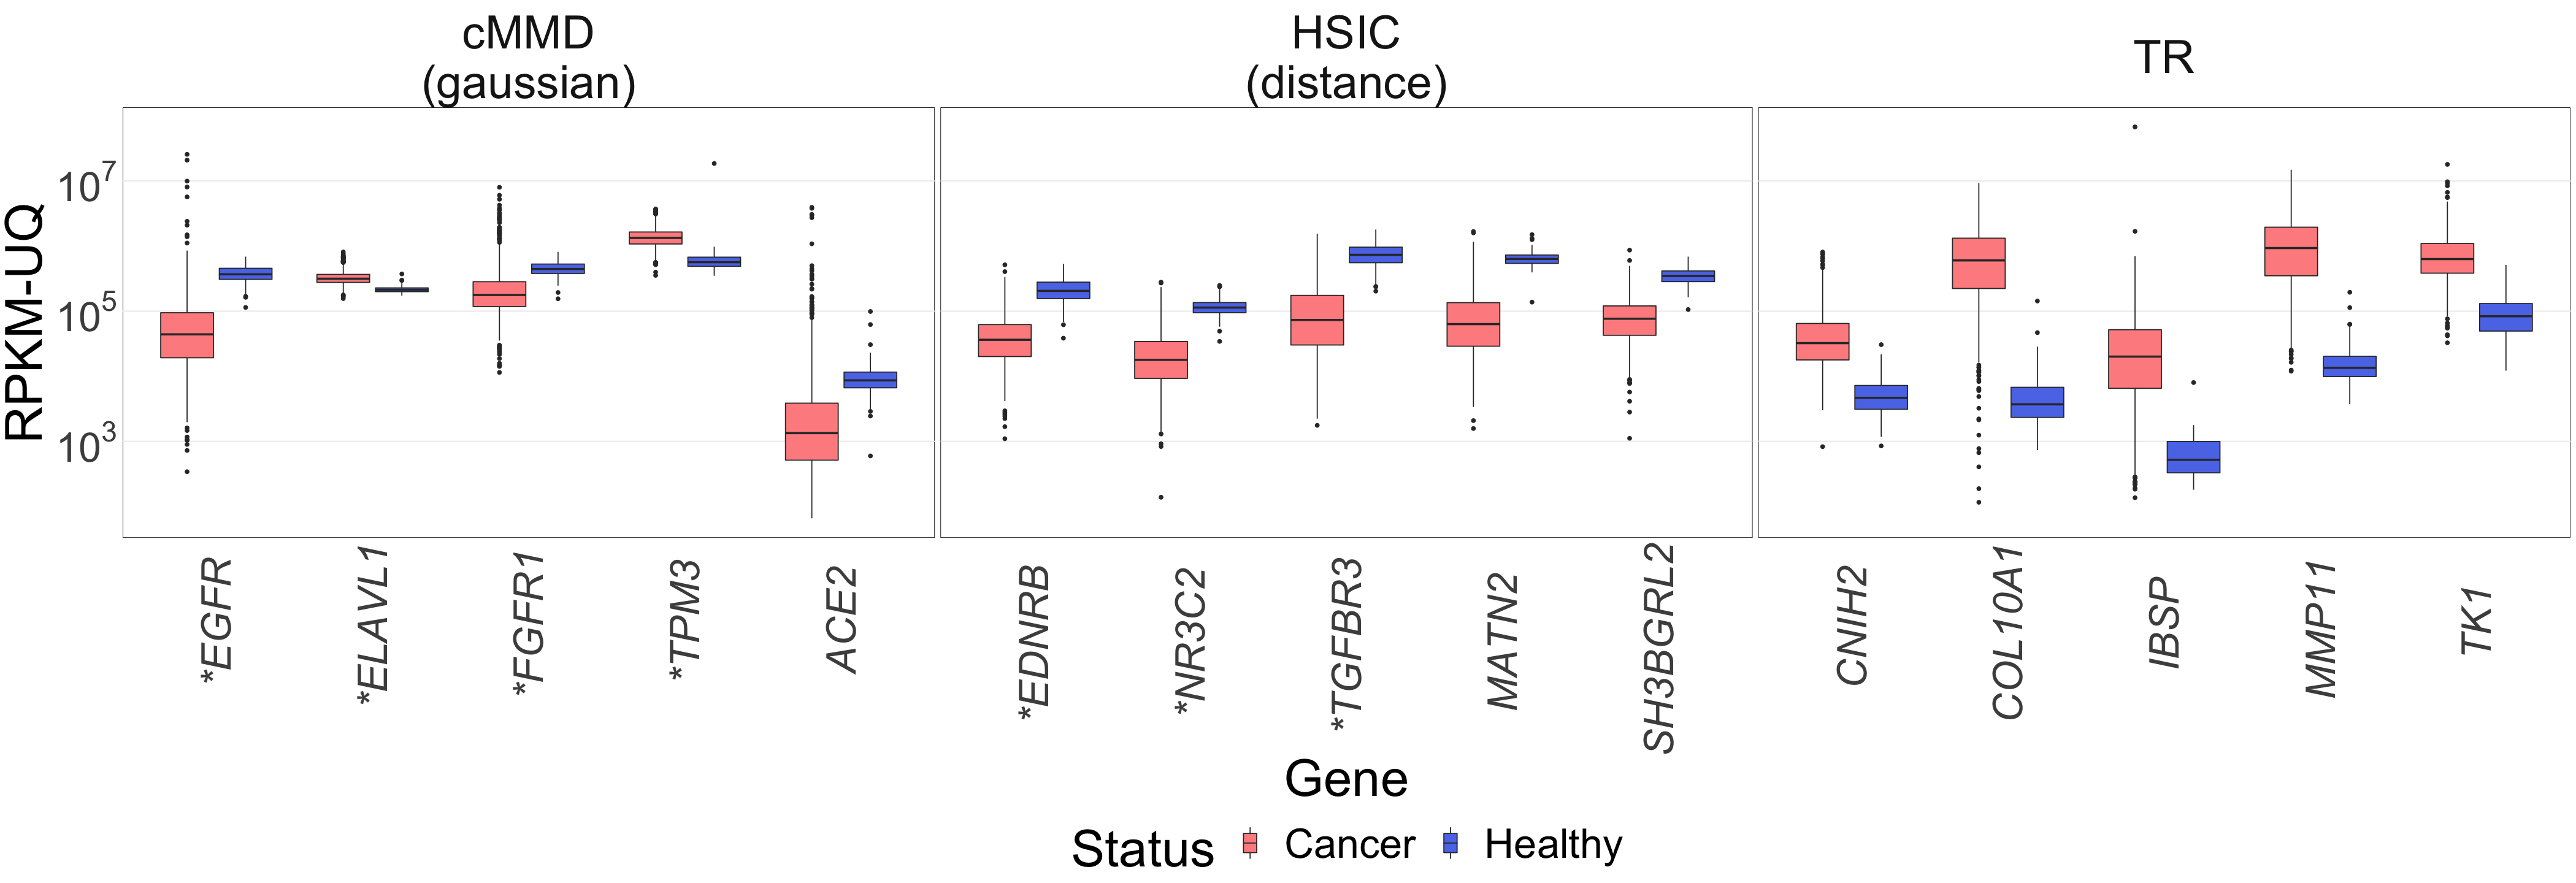

In [60]:
library(scales)

labels <- select(top_5, gene, AM) %>% unique

top_5_plt <- lapply(top_5$feature, function(i) {
    tibble(x = X[,i + 1],
           y = as.character(y),
           gene = genes[i+1])
}) %>%
    bind_rows %>%
    inner_join(labels) %>%
    mutate(y = ifelse(y == 1, 'Cancer', 'Healthy'),
           gene = ifelse(gene %in% cancer_genes, paste0('*', gene), gene)) %>%
    ggplot(aes(x = gene, y = x, fill = y)) +
        geom_boxplot() +
        scale_y_log10(labels = trans_format("log10", math_format(10^.x))) +
        labs(x = 'Gene', y = 'RPKM-UQ', fill = 'Status') +
        scale_fill_manual(values = c('Cancer' = '#FE8F8F',
                                     'Healthy' = '#5C7AEA')) +
        theme_minimal() +
        facet_grid(. ~ AM, scales = 'free') +
        theme_transparent +
        theme(axis.text.x = element_text(size = 40, angle = 90, vjust = .5, 
                                         hjust = .6, face = 'italic'),
              text = element_text(size = 50),
              plot.title = element_text(size = 70),
              strip.text.x = element_text(size = 45),
              legend.position = 'bottom',
              panel.grid.major.y = element_line())

options(repr.plot.width=35, repr.plot.height=12)
top_5_plt

In [7]:
brca <- read_csv('../results/real_world/brca_scores_folds.csv', col_types = 'cicdcddd') %>%
    mutate(features = strsplit(features, ',')) %>%
    mutate(AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM)) %>%
    unnest(features) %>%
    mutate(features = genes[as.numeric(features) + 1])

In [8]:
options(repr.plot.width=15, repr.plot.height=7)
acc_plt <- brca %>%
    select(fold, AM, alpha, accuracy, sensitivity, specificity) %>%
    group_by(AM, alpha) %>%
    summarize(sd = 1.96 * sd(accuracy, na.rm = TRUE) / sqrt(n()), # fix
              accuracy = mean(accuracy, na.rm = TRUE)) %>%
    ggplot(aes(y = accuracy, x = AM)) +
        geom_bar(aes(alpha = as.character(alpha)),
                 stat = 'identity', position = 'dodge', 
                 fill = 'red', color = 'black', ) +
        geom_errorbar(aes(ymin = accuracy - sd, 
                          ymax = accuracy + sd,
                          group = alpha), 
                      position=position_dodge(width = .9), width = .5, size = .7) +
        labs(y = 'Test accuracy', x = 'Association measure', alpha = expression(alpha)) +
        guides(alpha = guide_legend(nrow = 2))+ 
        theme_minimal() +
        theme_transparent +
        theme(text = element_text(size = 25),
              legend.text=element_text(size=15),
              legend.position = 'bottom',
              panel.grid.major.y = element_line())

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



In [9]:
num_features_plt <- brca %>%
    group_by(alpha, AM, fold) %>%
    summarize(n_features = n()) %>%
    group_by(alpha, AM) %>%
    summarize(sd = 1.96 * sd(n_features) / sqrt(n()), # fix
              n_features = mean(n_features)) %>%
    mutate(n_features = ifelse(AM == 'PC', n_features + .6, n_features),
           n_features = ifelse(AM == 'TR', n_features - .6, n_features),
           n_features = ifelse(AM == 'cMMD\n(gaussian)', n_features + .5, n_features),
           n_features = ifelse(AM == 'HSIC\n(gaussian)', n_features - .5, n_features)) %>%
    ggplot(aes(x = alpha, y = n_features, color = AM)) +
        geom_point(size = 4) +
        geom_errorbar(aes(ymin = n_features - sd, ymax = n_features + sd), 
                      width = 0.02, size = 1) +
        geom_line(size = 1.5) +
        guides(color = guide_legend(nrow = 1))+ 
        labs(y = '# features', color = 'Association measure', x = expression(alpha)) +
        theme_minimal() +
        theme_transparent +
        theme(text = element_text(size = 25),
              legend.position = 'bottom',
              panel.grid.major.y = element_line()) +
        scale_color_manual(values = color_palette)

`summarise()` has grouped output by 'alpha', 'AM'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



In [10]:
compute_pearson <- function(selection_vectors) {
    
    pearsons <- lapply(selection_vectors, function(x) {
        suppressWarnings(
            lapply(selection_vectors, cor, x)
        )
    }) %>% 
        unlist %>%
        matrix(nrow = length(selection_vectors))
    
    diag(pearsons) <- NA
    
    mean(pearsons, na.rm = TRUE)    
    
}

feature_vectors <- brca %>%
    group_by(alpha, AM, fold) %>%
    summarise(features = list(genes %in% features))

pearsons <- lapply(unique(brca$AM), function(am) {
        lapply(unique(brca$alpha), function(a) {
            
            selection_vectors <- filter(feature_vectors, AM == am, alpha == a)$features
            
            tibble(AM = am,
                   alpha = a,
                   pearson = compute_pearson(selection_vectors))

        })
}) %>% bind_rows

`summarise()` has grouped output by 'alpha', 'AM'. You can override using the `.groups` argument.



In [11]:
missing_plt <- read_csv('../results/real_world/brca_scores_folds.csv', col_types = 'cicdcddd') %>%
    mutate(AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM)) %>%
    group_by(AM, alpha) %>%
    summarize(missing = sum(is.na(features))) %>%
    mutate(missing = ifelse(AM == 'PC', missing + .1, missing),
           missing = ifelse(AM == 'TR', missing - .1, missing),
           missing = ifelse(AM == 'cMMD\n(gaussian)', missing + .04, missing),
           missing = ifelse(AM == 'HSIC\n(gaussian)', missing - .04, missing)) %>%
    ggplot(aes(x = alpha, y = missing, color = AM)) +
        geom_point(size = 4) +
        geom_line(size = 1.5) +
        labs(y = '# folds no selection', color = 'Association measure', x = expression(alpha)) +
        scale_y_continuous(limits = c(0, 8)) +
        theme_minimal() +
        theme_transparent +
        theme(text = element_text(size = 25),
              legend.position = 'none',
              panel.grid.major.y = element_line()) +
        scale_color_manual(values = color_palette)

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



In [12]:
pearson_plt <- pearsons %>%
    mutate(pearson = ifelse(AM == 'cMMD\n(gaussian)', pearson + .003, pearson),
           pearson = ifelse(AM == 'HSIC\n(gaussian)', pearson - .003, pearson)) %>%
    ggplot(aes(alpha, pearson, color = AM)) +
        geom_point(size = 4) +
        geom_line(size = 1.5) +
        labs(y = 'Cross-fold correlation', color = 'Association measure', 
             x = expression(alpha)) +
        theme_minimal() +
        theme_transparent +
        theme(text = element_text(size = 25),
              legend.position = 'none',
              panel.grid.major.y = element_line()) +
        scale_color_manual(values = color_palette)

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 14 rows containing missing values (geom_bar).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 rows containing missing values (geom_point).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


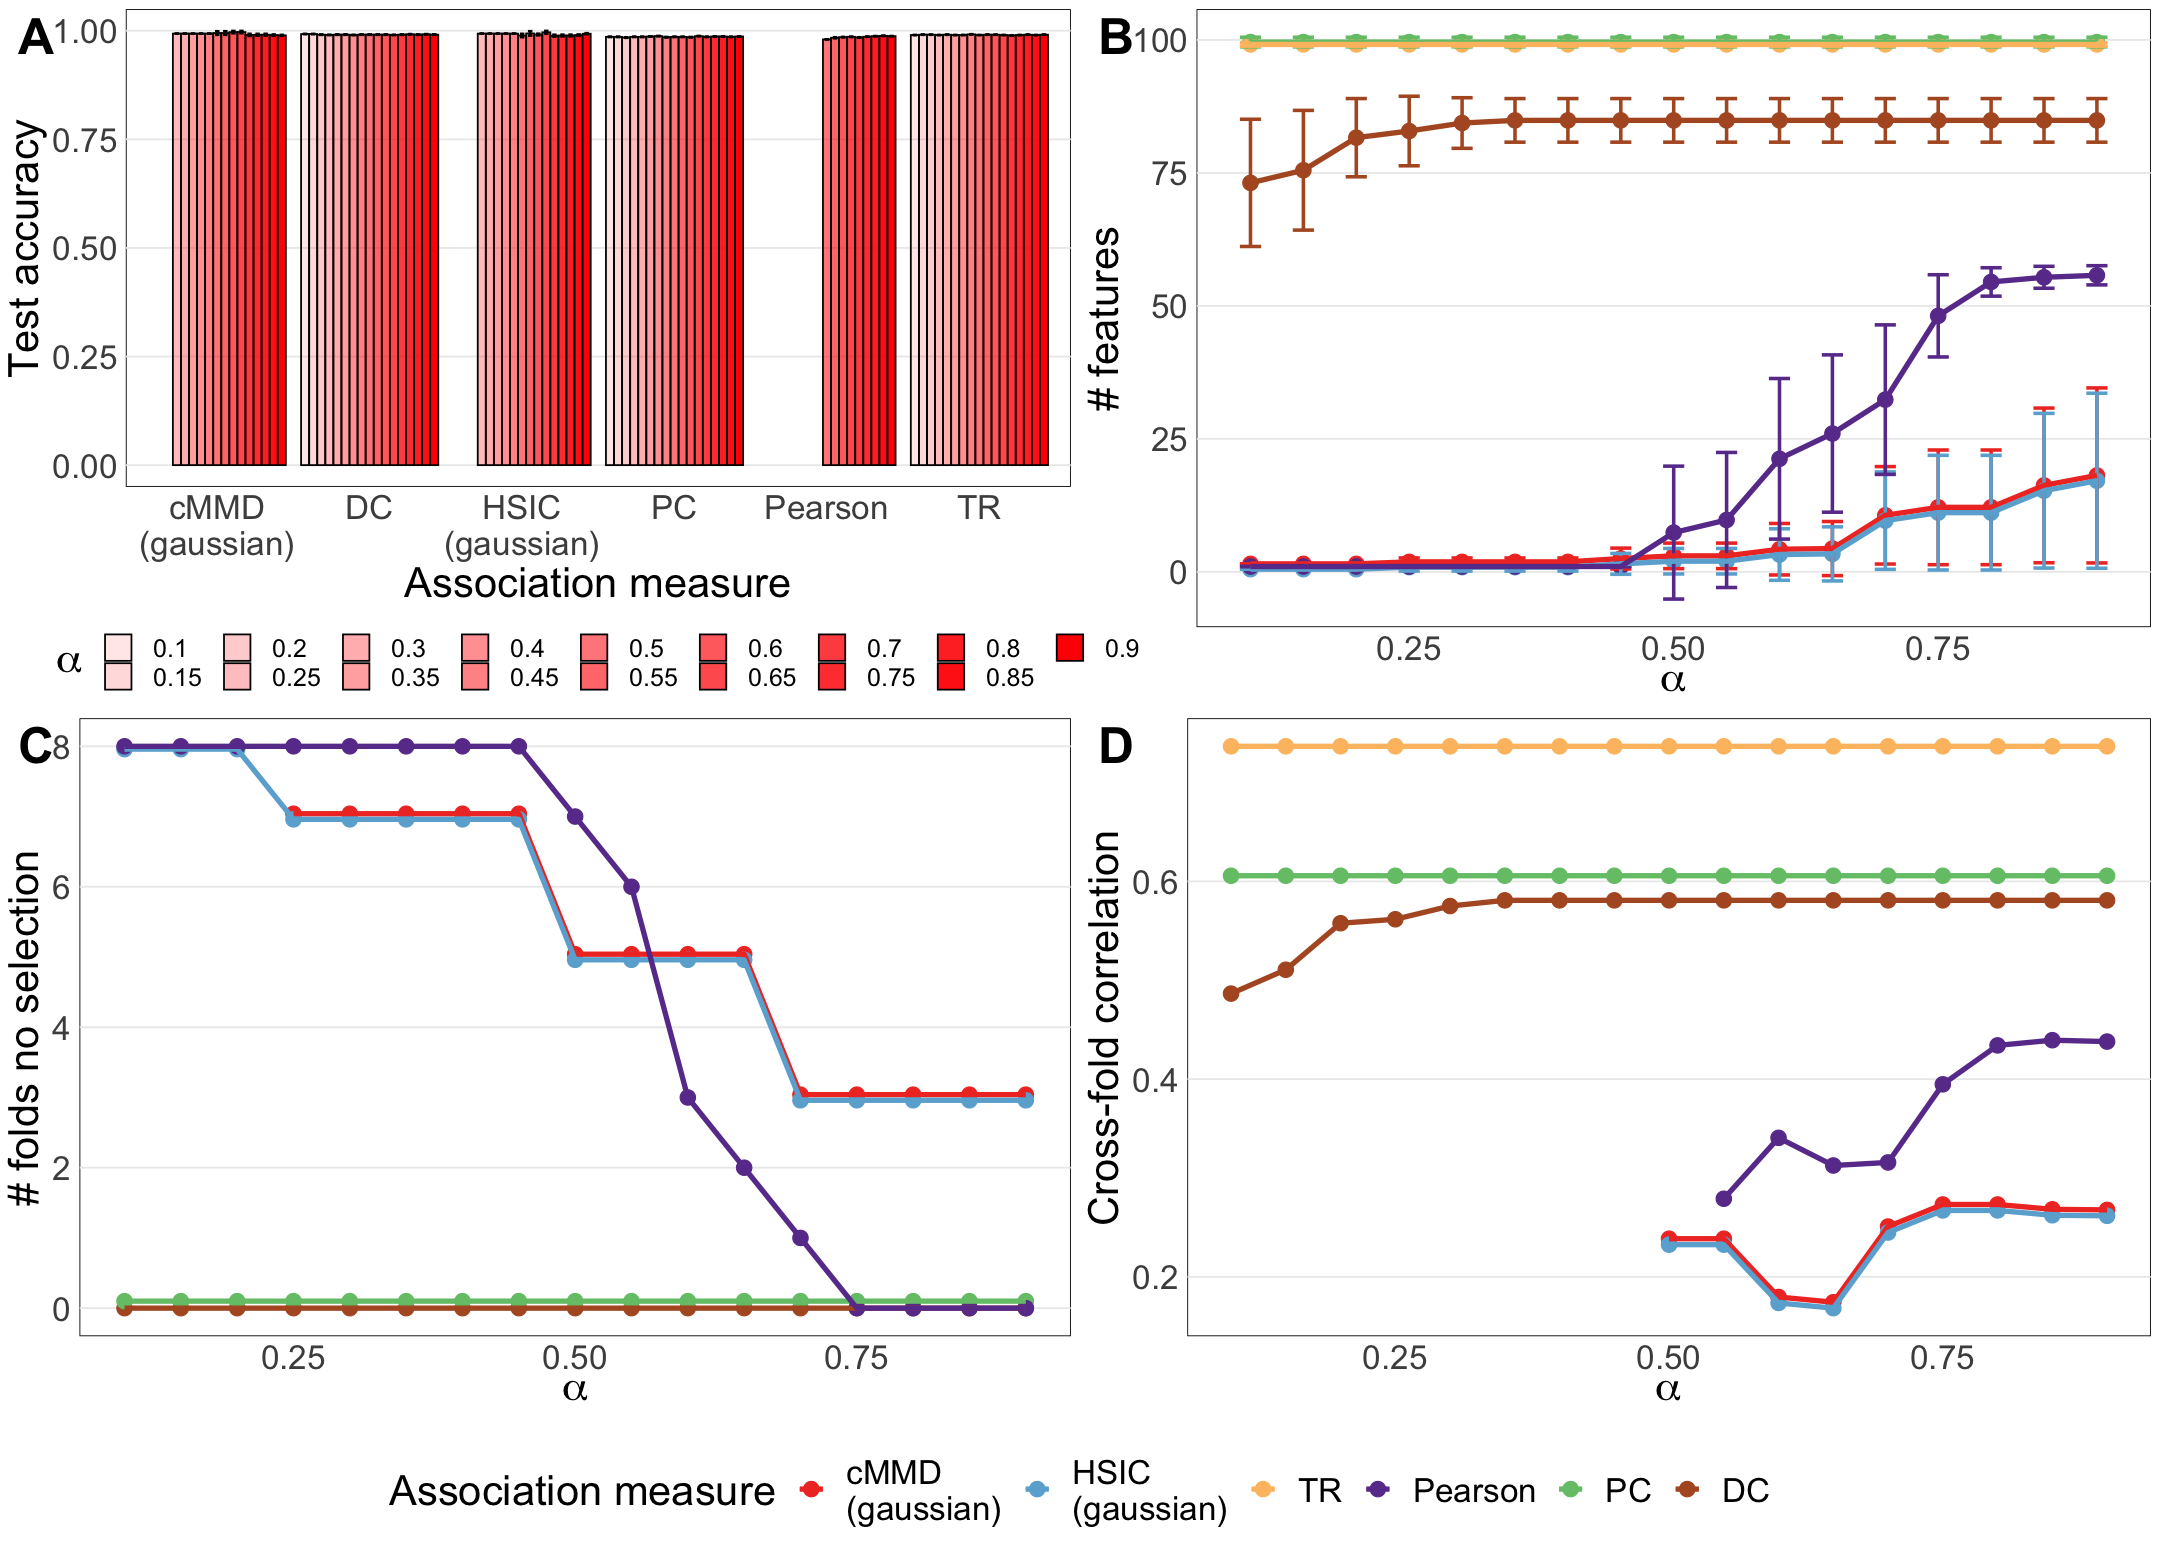

In [13]:
options(repr.plot.width=18, repr.plot.height=13)

plot_grid(plot_grid(acc_plt, num_features_plt + theme(legend.position = 'none'), 
                    missing_plt, pearson_plt,
                    labels = c('A', 'B', 'C', 'D'), label_size = 30, ncol = 2),
          get_legend(num_features_plt), nrow = 2, rel_heights = c(1, .1))
ggsave('../results/real_world/brca_supp.pdf', width=18, height=13, bg = "transparent")

# MNIST

In [14]:
i <- np$load("../results/real_world/avg_number.npz", allow_pickle=TRUE)

seven = i$f[['seven']]
three = i$f[['three']]

In [15]:
selected_features <- read_csv('../results/real_world/mnist_scores_folds.csv',
         col_types = 'cicdcddd') %>%
    mutate(features = strsplit(features, ','),
           AM = ifelse(AM == 'pearson_correlation', 'Pearson', AM),
           AM = ifelse(AM == 'HSIC', 'HSIC\n(gaussian)', AM),
           AM = ifelse(AM == 'MMD', 'cMMD\n(gaussian)', AM))

mean_alpha <- selected_features %>%
    unnest(features) %>%
    group_by(AM, features) %>%
    summarize(mean_alpha = mean(alpha)) %>%
    mutate(feature = as.numeric(features)) %>%
    ungroup %>% 
    add_row(AM = 'Raw', feature = 1, mean_alpha = 1) %>%
    mutate(AM = factor(AM, levels = c('Raw', 'cMMD\n(gaussian)', 'DC', 
                                      'HSIC\n(gaussian)', 'PC', 'Pearson', 'TR')))

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



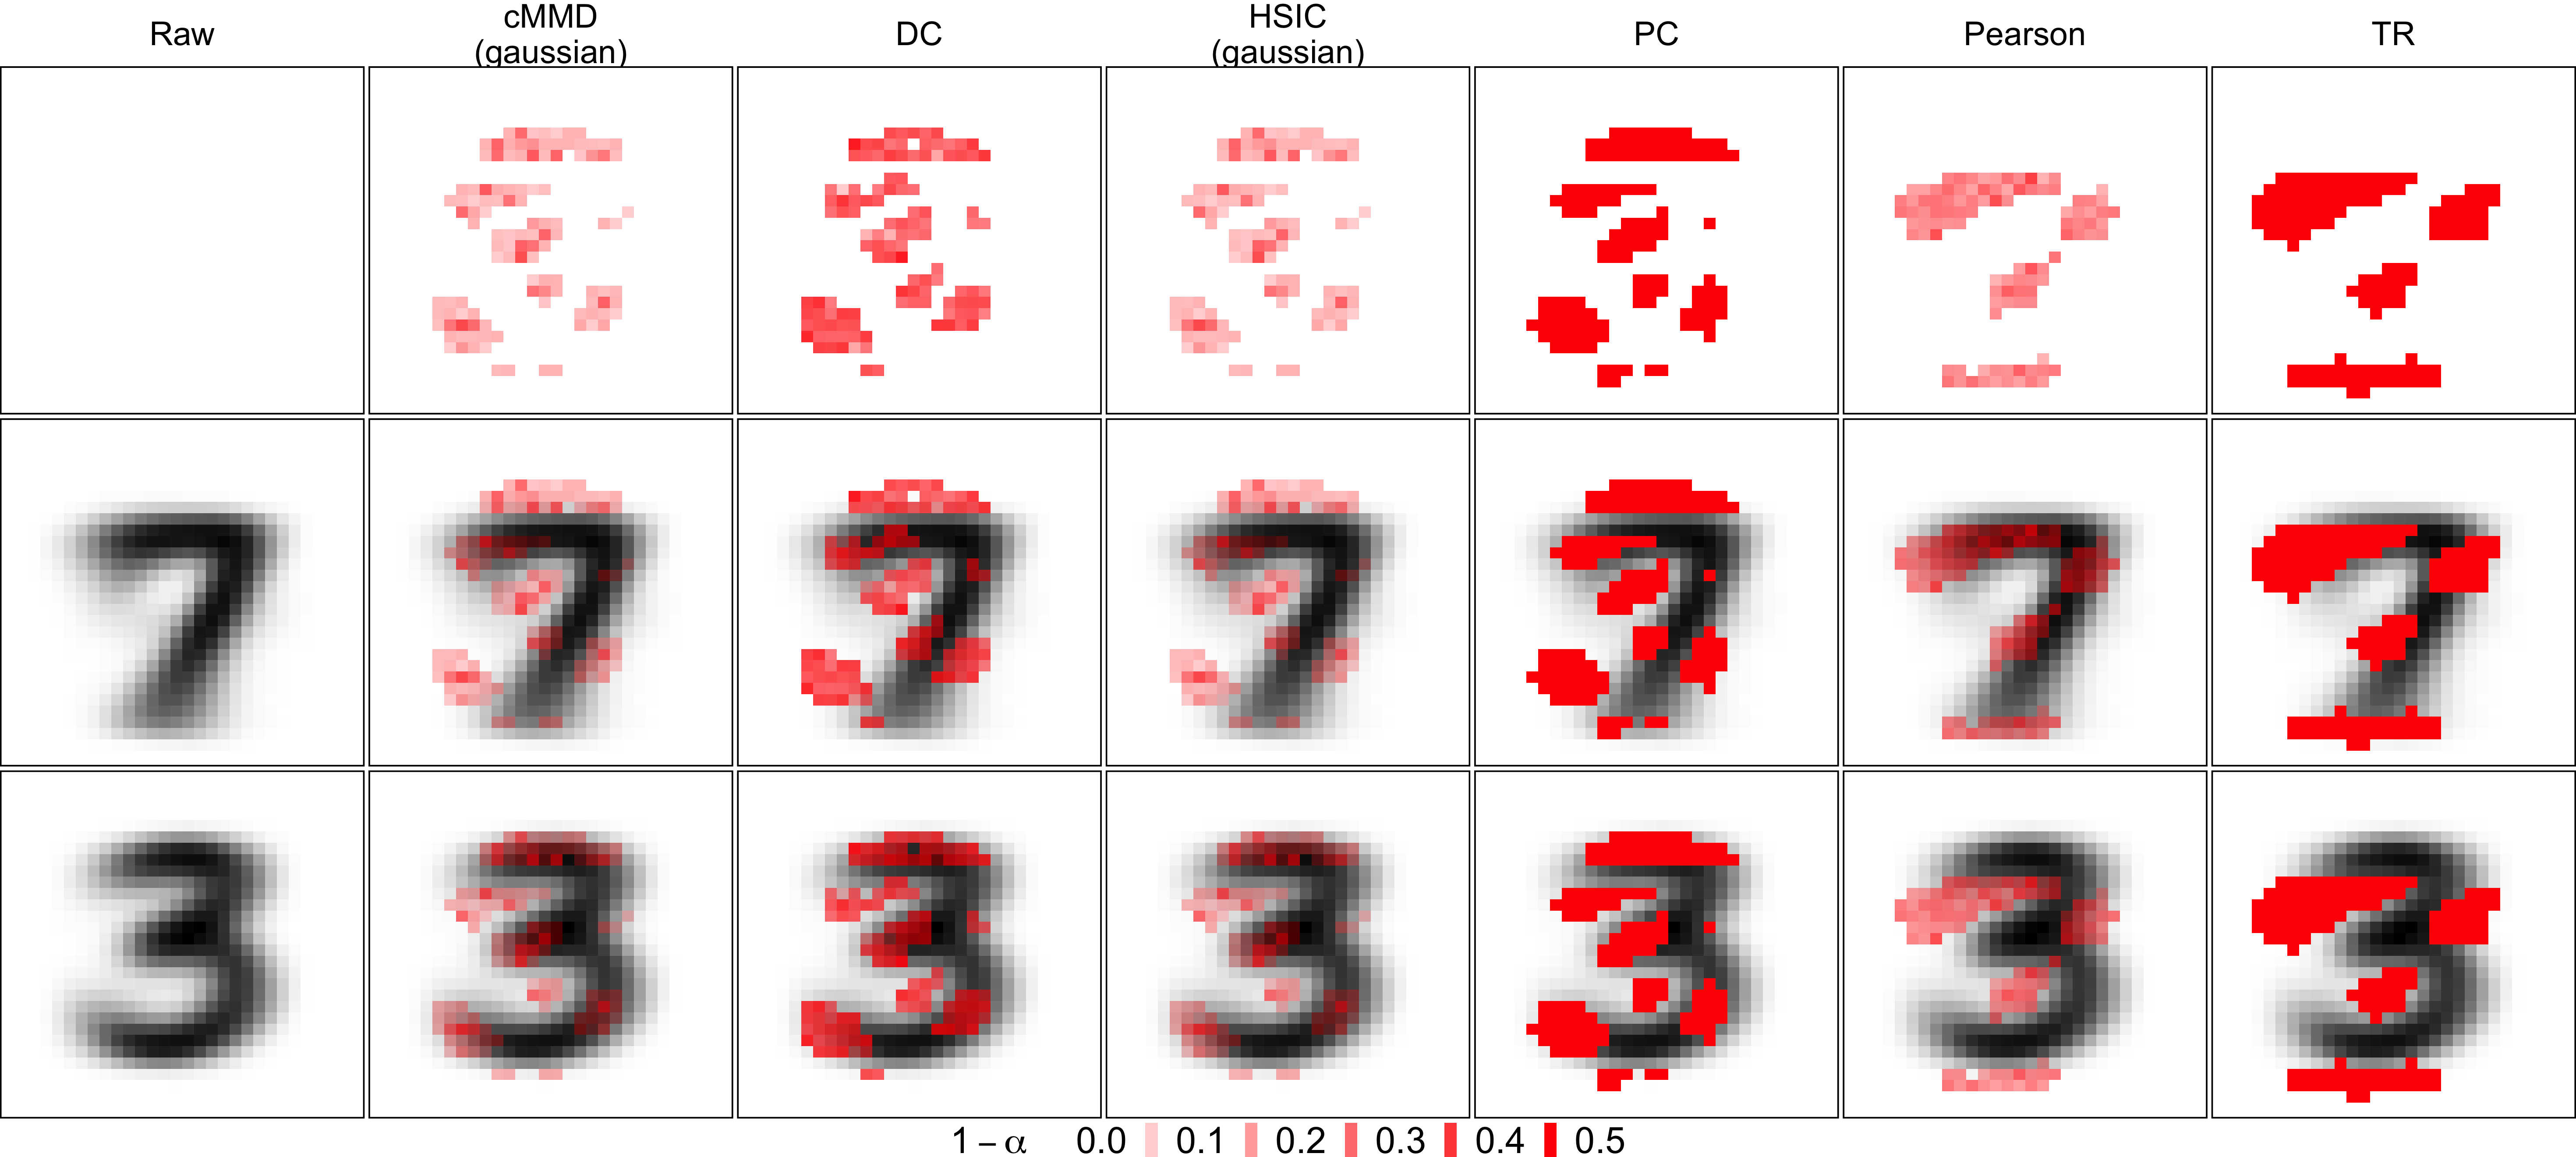

In [16]:
get_mnist <- function(mat, label) {
    
    tibble(x = rep(seq(1, 28), 28)) %>%
        mutate(y = sort(x, decreasing = TRUE),
               feature = row_number(),
               weight = as.numeric(mat),
               number = label)
    
}

mnist <- rbind(get_mnist(rep(0, 784), 'none'),
               get_mnist(three, 'three'),
               get_mnist(seven, 'seven'))

options(repr.plot.width=49, repr.plot.height=22)
mnist_img_plot <- ggplot(mnist, aes(x, y, fill = weight)) +
    geom_tile() +
    geom_tile(data = inner_join(mnist, mean_alpha, by = 'feature'), 
              aes(x, y, alpha = 1 - mean_alpha), fill = 'red') +
    scale_fill_gradient(low = 'white', high = 'black') +
    scale_alpha(range = c(0, 1)) +
    labs(alpha = expression(1 - alpha)) +
    facet_grid(number ~ AM) + 
    guides(fill = 'none', alpha = guide_legend(nrow = 1)) +
    theme_void() +
    theme_transparent +
    theme(legend.position = 'bottom',
          legend.text = element_text(size = 50),
          legend.title = element_text(size = 50),
          plot.title = element_text(size = 70),
          strip.text.x = element_text(size = 45),
          strip.text.y = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=2))
mnist_img_plot

In [17]:
mnist_acc_plot <- selected_features %>%
    group_by(AM, alpha) %>%
    summarize(sd = 1.96 * sd(accuracy, na.rm = TRUE) / sqrt(n()), # fix
              accuracy = mean(accuracy, na.rm = TRUE)) %>%
    ggplot(aes(y = accuracy, x = AM)) +
        geom_bar(aes(alpha = as.character(alpha)),
                 stat = 'identity', position = 'dodge', 
                 fill = 'red', color = 'black', ) +
        geom_errorbar(aes(ymin = accuracy - sd, 
                          ymax = accuracy + sd,
                          group = alpha), 
                      position=position_dodge(width = .9), width = .7, size = 1.5) +
        labs(y = 'Test accuracy', x = 'Association measure', alpha = expression(alpha)) +
        guides(alpha = guide_legend(nrow = 2)) +
        theme_minimal() +
        theme_transparent +
        theme(text = element_text(size = 50),
              plot.title = element_text(size = 55),
              legend.position = 'bottom',
              panel.grid.major.y = element_line())

`summarise()` has grouped output by 'AM'. You can override using the `.groups` argument.



In [18]:
mnist_cardinality_plot <- selected_features %>%
    mutate(n_features = lapply(features, length) %>% unlist,
           n_features = ifelse(is.na(features), 0, n_features)) %>%
    group_by(alpha, AM) %>%
    summarize(sd = 1.96 * sd(n_features) / sqrt(n()), # fix
              n_features = mean(n_features)) %>%
    # nudge features to avoid overlaps
    mutate(n_features = ifelse(AM == 'TR', n_features + .6, n_features),
           n_features = ifelse(AM == 'PC', n_features - .6, n_features),
           n_features = ifelse(AM == 'cMMD\n(gaussian)', n_features + .6, n_features),
           n_features = ifelse(AM == 'HSIC\n(gaussian)', n_features - .6, n_features)) %>%
    ggplot(aes(x = alpha, y = n_features, color = AM)) +
        geom_point(size = 10) +
        geom_errorbar(aes(ymin = n_features - sd, ymax = n_features + sd), 
                      width = 0.02, size = 2) +
        geom_line(size = 3) +
        labs(y = '# features', color = 'Association measure', x = expression(alpha)) +
        scale_color_manual(values = color_palette) +
        theme_minimal() +
        theme_transparent +
        theme(text = element_text(size = 50),
              plot.title = element_text(size = 55),
              legend.position = 'bottom',
              panel.grid.major.y = element_line())

`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 11 rows containing missing values (geom_bar).”


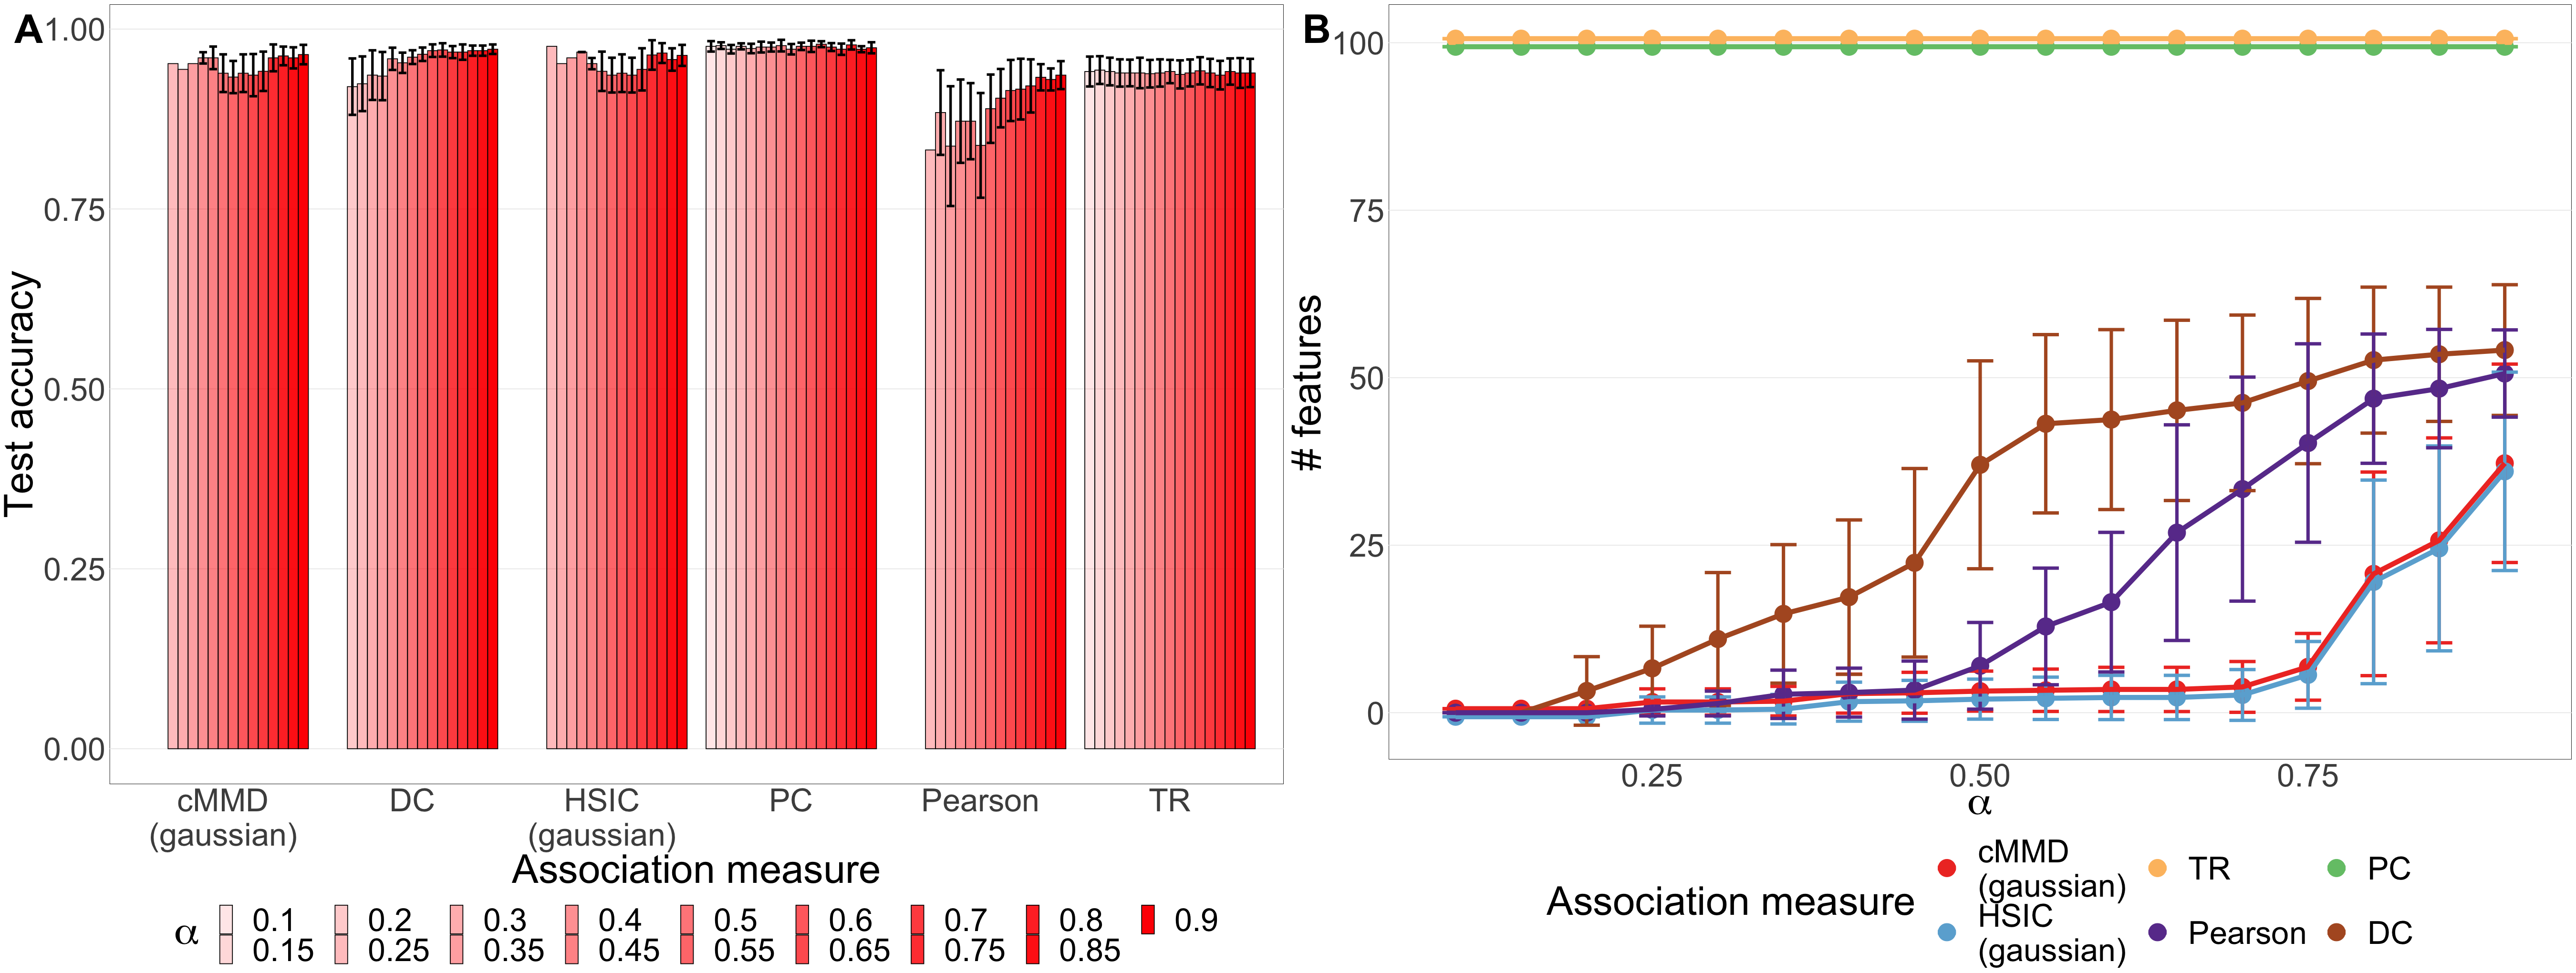

In [19]:
options(repr.plot.width=45, repr.plot.height=17)
plot_grid(mnist_acc_plot, mnist_cardinality_plot, 
          labels = c('A','B'), label_size = 50)
ggsave('../results/real_world/mnist_cardinality.pdf', width=45, height=17, bg = "transparent")

# Main figure

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 136 rows containing non-finite values (stat_boxplot).”


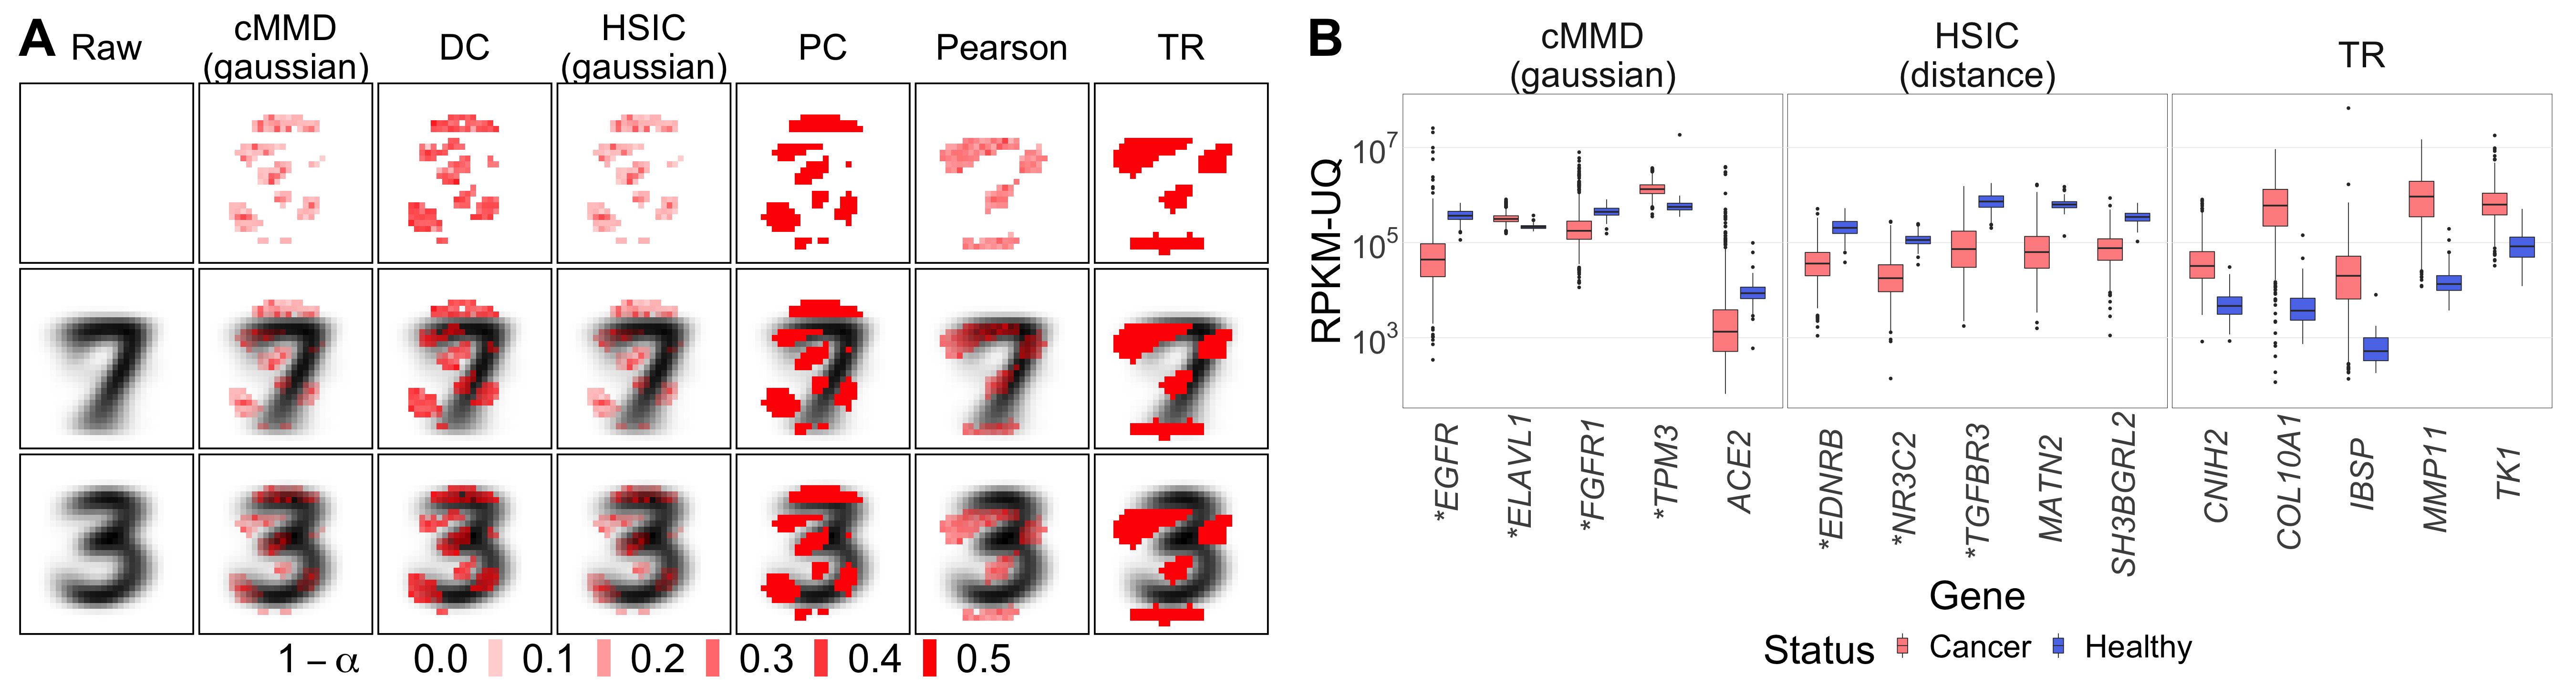

In [61]:
options(repr.plot.width=45, repr.plot.height=12)
plot_grid(mnist_img_plot,top_5_plt,
          ncol = 2, scale = 0.97, labels = c('A', 'B'), label_size = 65)
ggsave('../results/real_world/real_world_figure.pdf', width=45, height=12, bg = "transparent")

In [62]:
length(cancer_genes)

[1] 7